<a href="https://colab.research.google.com/github/hamednasr/deep-learning/blob/main/my_code_challenge_Xavier_vs_Kaiming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [96]:
### import libraries

# for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

# for number-crunching
import numpy as np
import scipy.stats as stats

# for dataset management
import pandas as pd

# for data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

# Import and process the data

In [97]:
# import the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url,sep=';')
data = data[data['total sulfur dioxide']<200] # drop a few outliers

# z-score all columns except for quality
cols2zscore = data.keys()
cols2zscore = cols2zscore.drop('quality')
data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

# create a new column for binarized (boolean) quality
data['boolQuality'] = 0
# data['boolQuality'][data['quality']<6] = 0 # implicit in the code! just here for clarity
data['boolQuality'][data['quality']>5] = 1

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [98]:
# convert from pandas dataframe to tensor
dataT  = torch.tensor( data[cols2zscore].values ).float()
labels = torch.tensor( data['boolQuality'].values ).float()
labels = labels[:,None] # transform to matrix

# use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_dataDataset = torch.utils.data.TensorDataset(train_data,train_labels)
test_dataDataset  = torch.utils.data.TensorDataset(test_data,test_labels)

# finally, create dataloaders
train_loader = DataLoader(train_dataDataset,batch_size=32, shuffle=True, drop_last=True)
test_loader  = DataLoader(test_dataDataset,batch_size=test_dataDataset.tensors[0].shape[0])

# Now for the DL part

In [99]:
# create a class for the model

class ANNwine(nn.Module):
  def __init__(self):
    super().__init__()

    ### input layer
    self.input = nn.Linear(11,16)
    
    ### hidden layers
    self.fc1 = nn.Linear(16,32)
    self.fc2 = nn.Linear(32,32)

    ### output layer
    self.output = nn.Linear(32,1)
  
  # forward pass
  def forward(self,x):
    x = F.relu( self.input(x) )
    x = F.relu( self.fc1(x) )
    x = F.relu( self.fc2(x) )
    return self.output(x)

# A function to train the model

In [100]:
# global parameter
numepochs =1000

def trainTheModel(winenet):

  # loss function and optimizer
  lossfun = nn.BCEWithLogitsLoss()
  optimizer = torch.optim.Adam(winenet.parameters(),lr=.001)

  # initialize losses
  losses   = np.zeros(numepochs)
  trainAcc = []
  testAcc  = []

  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = winenet(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute training accuracy for this batch
      batchAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    with torch.no_grad(): # deactivates autograd
      yHat = winenet(X)
    testAcc.append( 100*torch.mean(((yHat>0) == y).float()).item() )
  
  # function output
  return trainAcc,testAcc,losses

# Now to create the fitted model

In [101]:
# Kaiming inits
winenet_kaiming = ANNwine()
trainAccK,testAccK,lossesK = trainTheModel(winenet_kaiming)

In [102]:
# Xavier inits
winenet_xavier = ANNwine()
for layer in winenet_xavier.named_parameters():
  if 'weight' in layer[0]:
    nn.init.xavier_normal_(layer[1].data)

trainAccX,testAccX,lossesX = trainTheModel(winenet_xavier)

# Loss, Train and Test Accuracy

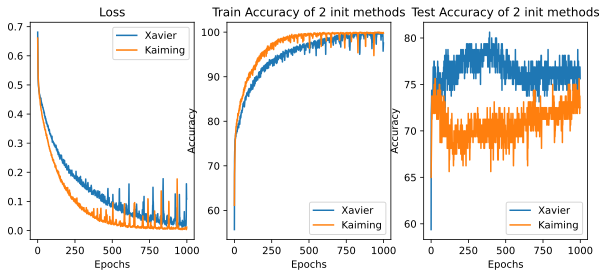

In [103]:
fig,ax = plt.subplots(1,3,figsize=(10,4))

ax[0].plot(lossesK)
ax[0].plot(lossesX)
ax[0].legend(['Xavier','Kaiming'])
ax[0].set_xlabel('Epochs')
ax[0].set_title('Loss')

ax[1].plot(trainAccK)
ax[1].plot(trainAccX)
ax[1].legend(['Xavier','Kaiming'])
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')
ax[1].set_title('Train Accuracy of 2 init methods')

ax[2].plot(testAccK)
ax[2].plot(testAccX)
ax[2].legend(['Xavier','Kaiming'])
ax[2].set_xlabel('Epochs')
ax[2].set_ylabel('Accuracy')
ax[2].set_title('Test Accuracy of 2 init methods')
plt.show()

In [104]:

results = np.empty((10,3,2))

for i in range(10):
  winenet_kaiming = ANNwine()
  trainAccK,testAccK,lossesK = trainTheModel(winenet_kaiming)

  winenet_xavier = ANNwine()
  for layer in winenet_xavier.named_parameters():
    if 'weight' in layer[0]:
      nn.init.xavier_normal_(layer[1].data)

  trainAccX,testAccX,lossesX = trainTheModel(winenet_xavier)

  results[i,0,0] = np.mean(lossesK[-5:])
  results[i,1,0] = np.mean(trainAccK[-5:])
  results[i,2,0] = np.mean(testAccK[-5:])

  results[i,0,1] = np.mean(lossesX[-5:])
  results[i,1,1] = np.mean(trainAccX[-5:])
  results[i,2,1] = np.mean(testAccX[-5:])

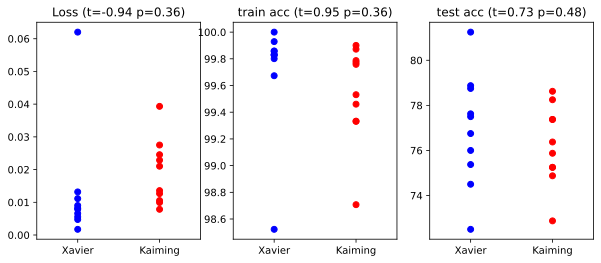

In [105]:
fig,ax = plt.subplots(1,3,figsize=(10,4))

ax[0].plot(np.zeros(10)+.5,results[:,0,1],'bo')
ax[0].plot(np.zeros(10)+1.5,results[:,0,0],'ro')
ax[0].set_xticks([.5,1.5])
ax[0].set_xticklabels(['Xavier','Kaiming'])
ax[0].set_xlim([0,2])
t, p = stats.ttest_ind(results[:,0,1],results[:,0,0])
ax[0].set_title(f'Loss (t={t:.2f} p={p:.2f})')

ax[1].plot(np.zeros(10)+.5,results[:,1,1],'bo')
ax[1].plot(np.zeros(10)+1.5,results[:,1,0],'ro')
ax[1].set_xticks([.5,1.5])
ax[1].set_xticklabels(['Xavier','Kaiming'])
ax[1].set_xlim([0,2])
t, p = stats.ttest_ind(results[:,1,1],results[:,1,0])
ax[1].set_title(f'train acc (t={t:.2f} p={p:.2f})')

ax[2].plot(np.zeros(10)+.5,results[:,2,1],'bo')
ax[2].plot(np.zeros(10)+1.5,results[:,2,0],'ro')
ax[2].set_xticks([.5,1.5])
ax[2].set_xticklabels(['Xavier','Kaiming'])
ax[2].set_xlim([0,2])
t, p = stats.ttest_ind(results[:,2,1],results[:,2,0])
ax[2].set_title(f'test acc (t={t:.2f} p={p:.2f})')

plt.show()